### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast


possible TODOs:

- try using google / model swap
- rate on various dimensions
- when doing summary, store the log length of the text for the summary
- store rating by source, bloomberg is high, normal pubs, prob garbage

spammy = has a relatively fact free headline with sensaitonal language.
only covers a stock movement or prediction without any basis in fact or sensational language
2 magnificent stocks
200 words is 0
divide chars by 1000 and take the log base 10
subtract 1 for spammy
add 1 for top source
delete less than 0 
only ai incidentally , ie ai predictions for nfl against the spread

"For each of the 100 summarized news stories, provide a rating on a scale of 1-10 for the following criteria:

Length (1 being too short or too long, 10 being optimal length)

Reputation of source (1 being unreliable, 10 being highly reputable)

Relevance/Importance (1 being trivial, 10 being highly significant)

Spamminess (1 being very spammy, 10 being not spammy at all)
- use exponential backoff to deal with rate limit issues (using metadata is not really well supported across llm providers, openai only gives time to reset in the http headers and not in the API itelf)
- do tests with promptfoo, promptlayer, do prompt optimization with eg dspy or your own thing
- scrape, extract, filter headlines, download pages, summarize, filter, categorize and sort, compose, rewrite


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
# del sys.modules['AInewsbot_langgraph']



In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainb_const import (
                        FINAL_SUMMARY_PROMPT,
                        REWRITE_PROMPT,
                        SCREENSHOT_DIR, SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainb_utilities import log

from AInewsbot_langgraph import (Agent, AgentState, newscatcher_sources, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from selenium.webdriver.support.ui import WebDriverWait
from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
LangChain         0.3.19
OpenAI            1.64.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

2025-03-03 09:10:27,448 - AInewsbot - INFO - Initializing with before_date=None, do_download=False, thread_id=e9388449f3b34a08b9606fddaf2afc45
2025-03-03 09:10:27,540 - AInewsbot - INFO - thread_id: e9388449f3b34a08b9606fddaf2afc45


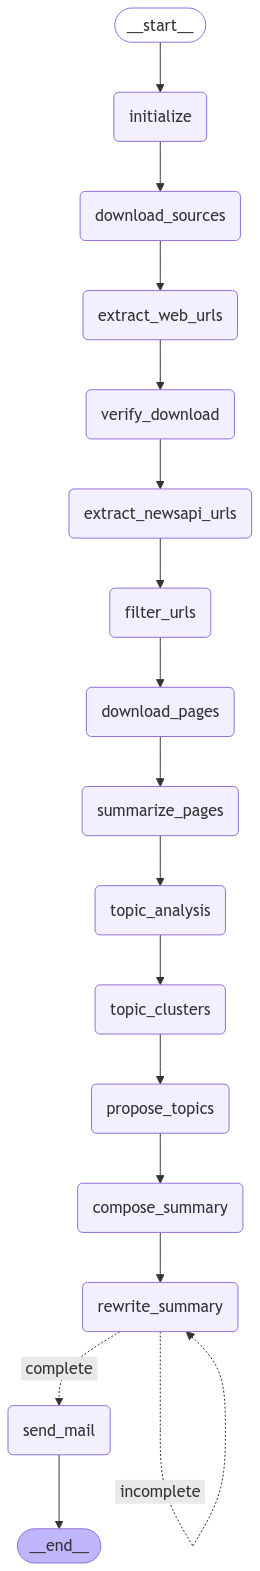

In [4]:
before_date = None
# before_date = '2025-03-02 15:00'
do_download = False

ml, mm, mh = 'gpt-4o-mini', 'gpt-4o-2024-11-20', 'o3-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=4)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [6]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


2025-03-03 09:11:18,362 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-03-03 09:11:18,363 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2025-03-03 09:11:18,363 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2025-03-03 09:11:18,364 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2025-03-03 09:11:18,364 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2025-03-03 09:11:18,364 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2025-03-03 09:11:18,365 - AInewsbot - INFO - 

run exception
'src'
run exception
'src'
run exception
'src'


2025-03-03 09:11:18,564 - AInewsbot - INFO - parse_file - found 262 raw links
2025-03-03 09:11:18,567 - AInewsbot - INFO - parse_file - found 29 filtered links
2025-03-03 09:11:18,568 - AInewsbot - INFO - 29 links found
2025-03-03 09:11:18,568 - AInewsbot - INFO - Hacker News 2 -> htmldata/Hacker News Page 2 (03_03_2025 08_50_51 AM).html
2025-03-03 09:11:18,579 - AInewsbot - INFO - parse_file - found 256 raw links
2025-03-03 09:11:18,582 - AInewsbot - INFO - parse_file - found 24 filtered links
2025-03-03 09:11:18,582 - AInewsbot - INFO - 24 links found
2025-03-03 09:11:18,583 - AInewsbot - INFO - HackerNoon -> htmldata/HackerNoon (03_03_2025 08_50_53 AM).html
2025-03-03 09:11:18,628 - AInewsbot - INFO - parse_file - found 581 raw links
2025-03-03 09:11:18,635 - AInewsbot - INFO - parse_file - found 100 filtered links
2025-03-03 09:11:18,636 - AInewsbot - INFO - 100 links found
2025-03-03 09:11:18,636 - AInewsbot - INFO - NYT Tech -> htmldata/New York Times Technology (03_03_2025 08_51

,id
src,
Ars Technica,32
Bloomberg Tech,12
Business Insider,22
FT Tech,64
Feedly AI,37
Hacker News,28
Hacker News 2,24
HackerNoon,99
NYT Tech,19


2025-03-03 09:11:19,030 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


,id
src,
Ars Technica,32
Bloomberg Tech,12
Business Insider,22
FT Tech,64
Feedly AI,37
Hacker News,28
Hacker News 2,24
HackerNoon,99
NYT Tech,19


2025-03-03 09:11:19,033 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-03-02T09:11:19 from NewsAPI


,id
src,
Ars Technica,32
Bloomberg Tech,12
Business Insider,22
FT Tech,64
Feedly AI,37
Hacker News,28
Hacker News 2,24
HackerNoon,99
NYT Tech,19


2025-03-03 09:11:19,270 - AInewsbot - INFO - Querying SQLite with where_clause: 
2025-03-03 09:11:19,972 - AInewsbot - INFO - URLs in orig_df: 860
2025-03-03 09:11:19,976 - AInewsbot - INFO - Existing URLs in DB: 225532
2025-03-03 09:11:20,034 - AInewsbot - INFO - New URLs in df filtered by URL: 55
2025-03-03 09:11:20,157 - AInewsbot - INFO - Existing src+title: 21
2025-03-03 09:11:20,158 - AInewsbot - INFO - New URLs in df filtered by src+title: 34
2025-03-03 09:11:20,170 - AInewsbot - INFO - Found 34 unique new headlines
2025-03-03 09:11:20,172 - AInewsbot - INFO - Found 34 unique cleaned new headlines
2025-03-03 09:11:27,952 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 09:11:27,994 - AInewsbot - INFO - Index(['id', 'url', 'src', 'title', 'isAI'], dtype='object')
2025-03-03 09:11:27,995 - AInewsbot - INFO - Inserting 34 URLs into articles.db
2025-03-03 09:11:28,029 - AInewsbot - INFO - Found 11 AI headlines
2025-03-03 09:

,id
src,
Feedly AI,5
Hacker News 2,1
NewsAPI,5


2025-03-03 09:11:28,037 - AInewsbot - INFO - Queuing URLs for scraping
2025-03-03 09:11:28,057 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 66223
2025-03-03 09:11:28,058 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 66223
2025-03-03 09:11:28,059 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 66223
2025-03-03 09:11:28,059 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 66223
2025-03-03 09:11:45,362 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-03-03 09:11:45,362 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-03-03 09:11:45,363 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-03-03 09:11:45,363 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-03-03 09:11:45,363 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-03-03 09:11:45,365 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-03-03 09:11:45,365 - AInewsb

2025-03-03 09:12:52,674 - AInewsbot - INFO - 3 pages saved
2025-03-03 09:12:53,232 - AInewsbot - INFO - 3 pages saved
2025-03-03 09:12:53,573 - AInewsbot - INFO - 3 pages saved
2025-03-03 09:13:14,698 - AInewsbot - INFO - Error fetching https://techcrunch.com/2025/03/03/jolla-founders-take-the-wraps-off-an-ai-assistant-to-power-up-their-push-for-privacy-friendly-genai/: Message: WebDriver session does not exist, or is not active
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:193:5
InvalidSessionIDError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:448:5
assert.that/<@chrome://remote/content/shared/webdriver/Assert.sys.mjs:515:13
assert.session@chrome://remote/content/shared/webdriver/Assert.sys.mjs:37:4
despatch@chrome://remote/content/marionette/server.sys.mjs:315:19
execute@chrome://remote/content/marionette/server.sys.mjs:289:16
onPacket/<@chrome://remote/content/marionet

,id
src,
Feedly AI,4
Hacker News 2,1
NewsAPI,5


2025-03-03 09:13:14,850 - AInewsbot - INFO - Starting summarize
2025-03-03 09:13:14,852 - AInewsbot - INFO - Fetching summaries for all articles
2025-03-03 09:13:14,905 - AInewsbot - INFO - clean_html - Page title: w33509.pdf

2025-03-03 09:13:15,160 - AInewsbot - INFO - Queuing 0: Page title: w33509.pdf
NBER WORKING PAPER SERIES
A...
2025-03-03 09:13:15,173 - AInewsbot - INFO - clean_html - Page title: Conversational Siri has to be spectacularly good if we won't get it until 2027
Social card title: Conversational Siri has to be spectacularly good if we won't get it until 2027
Social card description: One of the odder aspects of Apple’s history is that the company has gone in 14 years from one of...

2025-03-03 09:13:15,187 - AInewsbot - INFO - Queuing 1: Page title: Conversational Siri has to be spectacu...
2025-03-03 09:13:15,191 - AInewsbot - INFO - clean_html - Page title: Elon Musk’s Grok 3 makes a bold move as AI market intensifies
Social card title: Elon Musk’s Grok 3 makes a bo

2025-03-03 09:13:18,478 - AInewsbot - INFO - Summary for 6: - No content
2025-03-03 09:13:18,479 - AInewsbot - INFO - Summary for 7: • Chinese youth are turning to AI model DeepSeek for fortune-telling, blending traditional spiritual practices with technology amid societal anxiety in China.  

• US startup Firefly became the second private company to successfully land on the moon, furthering NASA’s goals to lower costs through private enterprise collaborations.  

• Donald Trump has proposed creating the first US strategic crypto reserve, sparking debate over its potential benefits and risks, including calls for the reserve to prioritize bitcoin.  
2025-03-03 09:13:18,479 - AInewsbot - INFO - Summary for 8: - no content
2025-03-03 09:13:18,480 - AInewsbot - INFO - Summary for 9: • TechCrunch created an AI glossary to define key terms used in their coverage, which will be updated regularly to reflect advancements and safety risks in artificial intelligence.  

• Key terms in the glossar

,id
src,
Feedly AI,4
Hacker News 2,1
NewsAPI,5


2025-03-03 09:13:18,501 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-03-03 09:13:21,603 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 09:13:21,650 - AInewsbot - INFO - 10 free-form topics extracted
2025-03-03 09:13:21,651 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-03-03 09:13:21,652 - AInewsbot - INFO - Canonical topic brain-computer interfaces
2025-03-03 09:13:21,652 - AInewsbot - INFO - Canonical topic donald trump
2025-03-03 09:13:21,652 - AInewsbot - INFO - Canonical topic education
2025-03-03 09:13:21,653 - AInewsbot - INFO - Canonical topic health & fitness
2025-03-03 09:13:21,653 - AInewsbot - INFO - Canonical topic inequality
2025-03-03 09:13:21,653 - AInewsbot - INFO - Canonical topic transformers
2025-03-03 09:13:21,653 - AInewsbot - INFO - Canonical topic funding

2025-03-03 09:13:23,825 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 09:13:23,867 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 09:13:23,875 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 09:13:23,889 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 09:13:23,915 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 09:13:23,931 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 09:13:23,970 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 09:13:23,981 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 09:13:23,986 - httpx 

2025-03-03 09:13:24,975 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 09:13:25,040 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 09:13:25,063 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 09:13:25,082 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 09:13:25,098 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 09:13:25,227 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 09:13:25,242 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 09:13:25,293 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 09:13:25,322 - httpx 

,id
src,
Feedly AI,4
Hacker News 2,1
NewsAPI,5


2025-03-03 09:13:28,989 - AInewsbot - INFO - Fetching embeddings for 10 headlines
2025-03-03 09:13:29,770 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-03-03 09:13:30,050 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-03-03 09:13:30,056 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-03-03 09:13:31,242 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-03-03 09:13:32,568 - AInewsbot - INFO - Cluster with DBSCAN
2025-03-03 09:13:32,623 - AInewsbot - INFO - Found 0 clusters
2025-03-03 09:13:32,713 - AInewsbot - INFO - Sending bullet points email
2025-03-03 09:13:34,027 - AInewsbot - INFO - []


bullets created


[This Brand Is Showing Samsung and Apple How AI Should Be Done - MakeUseOf](https://www.makeuseof.com/honor-mwc-2025-ai-alpha-plan-explained/)

Topics: AI Ecosystem, Artificial General Intelligence, Chatbots, Code Assistants, Collaboration With Qualcomm And Google Cloud, Computer Vision, Customer Service, Deals, Economics, Funding, Gen AI, Hardware, Honor AI Alpha Plan, Internet Of Things, Korea, Lifestyle & Travel, Mwc 2025, Open Source, Personal AI Agents, Products, Recommendation Systems, Robots, Science, Semiconductor Chips, Singularity, Travel, Virtual Assistants

- Honor unveiled its AI Alpha Plan at MWC 2025, shifting focus from devices to an AI ecosystem with open collaboration, including partnerships with Qualcomm and Google Cloud to enable agentic AI systems and support integration for other brands.  
- Highlighted features include a personal AI agent for tasks like restaurant reservations, AiMAGE for improved camera quality, and AI Upscale for restoring portraits; the company is investing over \\$10 billion in this vision over the next decade.  
- Alongside the AI Alpha Plan, Honor launched devices like the Magic Pad V9 tablet, Honor Watch 5 Ultra with 15-day battery life, and AI-powered Honor Earbuds Open, emphasizing innovation and cross-ecosystem collaboration.  



[The Download: DeepSeek for fortune telling, and the second private moon landing - Technology Review](https://www.technologyreview.com/2025/03/03/1112709/the-download-deepseek-for-fortune-telling-and-the-second-private-moon-landing/)

Topics: China, Consciousness, Crypto Reserve, Cryptocurrency, Deals, Deepseek AI, Donald Trump, Economics, Finance, Fintech, Fortune-Telling, Gen AI, Governance, Infrastructure, Language Models, Nasa And Private Enterprise, Policy And Regulation, Politics, Private Moon Landing, Science, Society & Culture, Transportation

• Chinese youth are turning to AI model DeepSeek for fortune-telling, blending traditional spiritual practices with technology amid societal anxiety in China.  

• US startup Firefly became the second private company to successfully land on the moon, furthering NASA’s goals to lower costs through private enterprise collaborations.  

• Donald Trump has proposed creating the first US strategic crypto reserve, sparking debate over its potential benefits and risks, including calls for the reserve to prioritize bitcoin.  



[Last chance! Last 24 hours to save up to \\$325 on Sessions: AI | TechCrunch - TechCrunch](https://techcrunch.com/2025/03/02/last-chance-last-24-hours-to-save-up-to-325-on-techcrunch-sessions-ai/)

Topics: AI Industry Networking, AI Safety, Bias And Fairness, Deals, Education, Ethics, Finance, Funding, Gen AI, Jobs & Careers, Korea, Language Models, Products, Safety And Alignment, Science, Techcrunch Sessions: AI, Venture Capital, Venture Capital In AI

• TechCrunch Sessions: AI is happening on June 5 at UC Berkeley, offering expert-led sessions, hands-on demos, and networking opportunities, with discounted registration ending by 11:59 p.m. PT today.  
• Key speakers include Jae Lee (CEO, Twelve Labs), Oliver Cameron (CEO, Odyssey), Kanu Gulati (Partner, Khosla Ventures), and Sara Hooker (VP of Research, Cohere), covering topics like foundational AI models and venture capital expectations.  
• Artemis Seaford (Head of AI Safety, ElevenLabs) and Jill Chase (Partner, CapitalG) will discuss responsible AI systems and funding insights in the AI industry.  



[Nvidia, Soundhound AI, Dell Technologies, And Meta Platforms Make Headlines: This Week In Artificial Intelligence - biztoc.com](https://biztoc.com/x/d422350e4c8c231c)

Topics: Artificial Intelligence News, Dell Technologies, Gen AI, Hardware, Meta Platforms, Nvidia, Science, Soundhound AI

- No content



[The TechCrunch AI glossary | TechCrunch - TechCrunch](https://techcrunch.com/2025/03/02/the-techcrunch-ai-glossary/)

Topics: AI Glossary, AI Terminology Updates, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Computer Vision, Cybersecurity, Education, Gen AI, Language Models, Large Language Models, Neural Networks, Retrieval Augmented Generation, Review, Safety And Alignment, Science, Singularity, Speech Recognition & Synthesis, Techcrunch, Virtual Assistants

• TechCrunch created an AI glossary to define key terms used in their coverage, which will be updated regularly to reflect advancements and safety risks in artificial intelligence.  

• Key terms in the glossary include "AI agent" (autonomous systems for multi-step tasks), "chain of thought" (breaking problems into steps for better outcomes), "deep learning" (multi-layered neural networks for complex correlations), and "fine-tuning" (specialized training for task-specific performance).  

• The glossary also covers "large language models" (e.g., GPT and ChatGPT as AI assistants) and foundational concepts like "neural networks" and "weights," critical for AI model training and functionality.  



[Elon Musks Grok 3 makes a bold move as AI market intensifies - biztoc.com](https://biztoc.com/x/3b6852cf4f36b5d3)

Topics: AI Market Competition, Elon Musk, Gen AI, Grok 3, Science

- no content



[The TechCrunch AI glossary - biztoc.com](https://biztoc.com/x/1027109362387f7e)

Topics: AI Terminology, Artificial Intelligence Definitions, Science, Techcrunch AI Glossary

- no content



[Conversational Siri has to be spectacularly good if we wont get it until 2027 - 9to5Mac](https://9to5mac.com/2025/03/03/conversational-siri-has-to-be-spectacularly-good-if-we-wont-get-it-until-2027/)

Topics: 2027 Launch Expectations, AI Privacy, Apple Siri, Chatbots, Conversational AI, Gen AI, Language Models, Privacy, Privacy & Surveillance, Products, Science, Speech Recognition & Synthesis, Virtual Assistants

- Apple's conversational Siri, expected to launch in 2027 or later, faces high expectations as competitors like ChatGPT and Alexa continue advancing rapidly.  
- Apple's focus on privacy and on-device processing has delayed Siri's progress compared to AI platforms that prioritize rapid development, but aims to provide a privacy-respecting AI assistant when ready.  
- The extended development timeline increases pressure for Siri to deliver groundbreaking capabilities to match or exceed future AI competitors.  



[Artificial Intelligence and the Labor Market [pdf] - www.nber.org](https://www.nber.org/system/files/working_papers/w33509/w33509.pdf)

Topics: Economic Impacts, Economics, Labor Market, Science

• No content



[Is AI chatbot Grok censoring criticism of Elon Musk and Donald Trump? - Euronews](https://www.euronews.com/2025/03/03/is-ai-chatbot-grok-censoring-criticism-of-elon-musk-and-donald-trump)

Topics: AI Chatbot Grok, Chatbots, Donald Trump, Elon Musk, Eu Asylum Applications, European Union, Governance, Inequality, Legal Issues, Migration Management, Policy And Regulation, Politics, Society & Culture

• The EU registered over 1 million asylum applications in 2024, with nearly half filed by applicants with low chances of approval. Germany remained the top destination country with more than 237,000 applications, though saw a 29% reduction from 2023.

• The European Commission is considering reforms like "return hubs" outside EU territory for rejected applicants, and plans to unveil a revamped Return Directive. Recognition rates for applicants varied significantly by nationality and host country.

• Despite EU-funded border control agreements and a 38% drop in irregular border crossings, pending asylum cases reached 981,000 by the end of 2024, highlighting challenges in managing migration and deportations.



2025-03-03 09:13:34,063 - AInewsbot - INFO - Proposing categories using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-03-03 09:13:34,064 - AInewsbot - INFO - Initial cluster topics: 

2025-03-03 09:13:45,456 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 09:13:45,476 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
Honor AI Ecosystem & Devices
Chinese AI Fortune Telling Trend
Private Moon Landing by Firefly
Trump’s Crypto Reserve Proposal
TechCrunch AI Sessions Event
Major AI Company Headlines
TechCrunch AI Glossary Launch
Elon Musk Grok 3 Update
Apple Conversational Siri Delay
AI Labor Market Impact
EU Asylum & Migration Reforms
2025-03-03 09:13:59,715 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 09:13:59,726 - AInewsbot - INFO - Final edited cluster topics using <class 'langchain_openai.chat_m

bullets created


[This Brand Is Showing Samsung and Apple How AI Should Be Done - MakeUseOf](https://www.makeuseof.com/honor-mwc-2025-ai-alpha-plan-explained/)

Topics: AI Ecosystem, Artificial General Intelligence, Chatbots, Code Assistants, Collaboration With Qualcomm And Google Cloud, Computer Vision, Customer Service, Deals, Economics, Funding, Gen AI, Hardware, Honor AI Alpha Plan, Internet Of Things, Korea, Lifestyle & Travel, Mwc 2025, Open Source, Personal AI Agents, Products, Recommendation Systems, Robots, Science, Semiconductor Chips, Singularity, Travel, Virtual Assistants

- Honor unveiled its AI Alpha Plan at MWC 2025, shifting focus from devices to an AI ecosystem with open collaboration, including partnerships with Qualcomm and Google Cloud to enable agentic AI systems and support integration for other brands.  
- Highlighted features include a personal AI agent for tasks like restaurant reservations, AiMAGE for improved camera quality, and AI Upscale for restoring portraits; the company is investing over \\$10 billion in this vision over the next decade.  
- Alongside the AI Alpha Plan, Honor launched devices like the Magic Pad V9 tablet, Honor Watch 5 Ultra with 15-day battery life, and AI-powered Honor Earbuds Open, emphasizing innovation and cross-ecosystem collaboration.  



[The Download: DeepSeek for fortune telling, and the second private moon landing - Technology Review](https://www.technologyreview.com/2025/03/03/1112709/the-download-deepseek-for-fortune-telling-and-the-second-private-moon-landing/)

Topics: China, Consciousness, Crypto Reserve, Cryptocurrency, Deals, Deepseek AI, Donald Trump, Economics, Finance, Fintech, Fortune-Telling, Gen AI, Governance, Infrastructure, Language Models, Nasa And Private Enterprise, Policy And Regulation, Politics, Private Moon Landing, Science, Society & Culture, Transportation

• Chinese youth are turning to AI model DeepSeek for fortune-telling, blending traditional spiritual practices with technology amid societal anxiety in China.  

• US startup Firefly became the second private company to successfully land on the moon, furthering NASA’s goals to lower costs through private enterprise collaborations.  

• Donald Trump has proposed creating the first US strategic crypto reserve, sparking debate over its potential benefits and risks, including calls for the reserve to prioritize bitcoin.  



[Last chance! Last 24 hours to save up to \\$325 on Sessions: AI | TechCrunch - TechCrunch](https://techcrunch.com/2025/03/02/last-chance-last-24-hours-to-save-up-to-325-on-techcrunch-sessions-ai/)

Topics: AI Industry Networking, AI Safety, Bias And Fairness, Deals, Education, Ethics, Finance, Funding, Gen AI, Jobs & Careers, Korea, Language Models, Products, Safety And Alignment, Science, Techcrunch Sessions: AI, Venture Capital, Venture Capital In AI

• TechCrunch Sessions: AI is happening on June 5 at UC Berkeley, offering expert-led sessions, hands-on demos, and networking opportunities, with discounted registration ending by 11:59 p.m. PT today.  
• Key speakers include Jae Lee (CEO, Twelve Labs), Oliver Cameron (CEO, Odyssey), Kanu Gulati (Partner, Khosla Ventures), and Sara Hooker (VP of Research, Cohere), covering topics like foundational AI models and venture capital expectations.  
• Artemis Seaford (Head of AI Safety, ElevenLabs) and Jill Chase (Partner, CapitalG) will discuss responsible AI systems and funding insights in the AI industry.  



[Nvidia, Soundhound AI, Dell Technologies, And Meta Platforms Make Headlines: This Week In Artificial Intelligence - biztoc.com](https://biztoc.com/x/d422350e4c8c231c)

Topics: Artificial Intelligence News, Dell Technologies, Gen AI, Hardware, Meta Platforms, Nvidia, Science, Soundhound AI

- No content



[The TechCrunch AI glossary | TechCrunch - TechCrunch](https://techcrunch.com/2025/03/02/the-techcrunch-ai-glossary/)

Topics: AI Glossary, AI Terminology Updates, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Computer Vision, Cybersecurity, Education, Gen AI, Language Models, Large Language Models, Neural Networks, Retrieval Augmented Generation, Review, Safety And Alignment, Science, Singularity, Speech Recognition & Synthesis, Techcrunch, Virtual Assistants

• TechCrunch created an AI glossary to define key terms used in their coverage, which will be updated regularly to reflect advancements and safety risks in artificial intelligence.  

• Key terms in the glossary include "AI agent" (autonomous systems for multi-step tasks), "chain of thought" (breaking problems into steps for better outcomes), "deep learning" (multi-layered neural networks for complex correlations), and "fine-tuning" (specialized training for task-specific performance).  

• The glossary also covers "large language models" (e.g., GPT and ChatGPT as AI assistants) and foundational concepts like "neural networks" and "weights," critical for AI model training and functionality.  



[Elon Musks Grok 3 makes a bold move as AI market intensifies - biztoc.com](https://biztoc.com/x/3b6852cf4f36b5d3)

Topics: AI Market Competition, Elon Musk, Gen AI, Grok 3, Science

- no content



[The TechCrunch AI glossary - biztoc.com](https://biztoc.com/x/1027109362387f7e)

Topics: AI Terminology, Artificial Intelligence Definitions, Science, Techcrunch AI Glossary

- no content



[Conversational Siri has to be spectacularly good if we wont get it until 2027 - 9to5Mac](https://9to5mac.com/2025/03/03/conversational-siri-has-to-be-spectacularly-good-if-we-wont-get-it-until-2027/)

Topics: 2027 Launch Expectations, AI Privacy, Apple Siri, Chatbots, Conversational AI, Gen AI, Language Models, Privacy, Privacy & Surveillance, Products, Science, Speech Recognition & Synthesis, Virtual Assistants

- Apple's conversational Siri, expected to launch in 2027 or later, faces high expectations as competitors like ChatGPT and Alexa continue advancing rapidly.  
- Apple's focus on privacy and on-device processing has delayed Siri's progress compared to AI platforms that prioritize rapid development, but aims to provide a privacy-respecting AI assistant when ready.  
- The extended development timeline increases pressure for Siri to deliver groundbreaking capabilities to match or exceed future AI competitors.  



[Artificial Intelligence and the Labor Market [pdf] - www.nber.org](https://www.nber.org/system/files/working_papers/w33509/w33509.pdf)

Topics: Economic Impacts, Economics, Labor Market, Science

• No content



[Is AI chatbot Grok censoring criticism of Elon Musk and Donald Trump? - Euronews](https://www.euronews.com/2025/03/03/is-ai-chatbot-grok-censoring-criticism-of-elon-musk-and-donald-trump)

Topics: AI Chatbot Grok, Chatbots, Donald Trump, Elon Musk, Eu Asylum Applications, European Union, Governance, Inequality, Legal Issues, Migration Management, Policy And Regulation, Politics, Society & Culture

• The EU registered over 1 million asylum applications in 2024, with nearly half filed by applicants with low chances of approval. Germany remained the top destination country with more than 237,000 applications, though saw a 29% reduction from 2023.

• The European Commission is considering reforms like "return hubs" outside EU territory for rejected applicants, and plans to unveil a revamped Return Directive. Recognition rates for applicants varied significantly by nationality and host country.

• Despite EU-funded border control agreements and a 38% drop in irregular border crossings, pending asylum cases reached 981,000 by the end of 2024, highlighting challenges in managing migration and deportations.



2025-03-03 09:13:59,737 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-03-03 09:14:27,789 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 09:14:27,795 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


summary created


# Alpha Ascension in Honor-land
- Honor unveiled its AI Alpha Plan at MWC 2025, shifting focus from devices to a collaborative AI ecosystem with partners like Qualcomm and Google Cloud to drive agentic systems - [MakeUseOf](https://www.makeuseof.com/honor-mwc-2025-ai-alpha-plan-explained/)
- The initiative spotlights innovative features such as a personal AI agent for tasks like restaurant reservations, AiMAGE for enhanced photo quality, and AI Upscale for portrait restoration, backed by a \\$10 billion investment vision - [MakeUseOf](https://www.makeuseof.com/honor-mwc-2025-ai-alpha-plan-explained/)
- Alongside its AI roadmap, Honor introduced new devices like the Magic Pad V9 tablet, Honor Watch 5 Ultra with 15-day battery life, and AI-powered Honor Earbuds Open to bolster cross-ecosystem innovation - [MakeUseOf](https://www.makeuseof.com/honor-mwc-2025-ai-alpha-plan-explained/)

# Mystic Moons & Digital Divinations
- Chinese youth are turning to AI model DeepSeek for fortune-telling, blending traditional spiritual practices with modern technology amid societal anxieties - [Technology Review](https://www.technologyreview.com/2025/03/03/1112709/the-download-deepseek-for-fortune-telling-and-the-second-private-moon-landing/)
- US startup Firefly became the second private company to land on the moon, marking a pivotal step in reducing space mission costs through private enterprise collaborations - [Technology Review](https://www.technologyreview.com/2025/03/03/1112709/the-download-deepseek-for-fortune-telling-and-the-second-private-moon-landing/)
- Donald Trump proposed establishing the first US strategic crypto reserve, sparking debates about its potential benefits and risks, with some advocating a focus on bitcoin - [Technology Review](https://www.technologyreview.com/2025/03/03/1112709/the-download-deepseek-for-fortune-telling-and-the-second-private-moon-landing/)

# Session Splendor
- TechCrunch Sessions: AI will take place on June 5 at UC Berkeley, featuring expert-led discussions, interactive demos, and networking opportunities with discounted registration ending soon - [TechCrunch](https://techcrunch.com/2025/03/02/last-chance-last-24-hours-to-save-up-to-325-on-techcrunch-sessions-ai/)
- Industry leaders including Jae Lee, Oliver Cameron, Kanu Gulati, and Sara Hooker are set to explore foundational AI models and venture capital trends during the event - [TechCrunch](https://techcrunch.com/2025/03/02/last-chance-last-24-hours-to-save-up-to-325-on-techcrunch-sessions-ai/)
- Experts Artemis Seaford and Jill Chase will discuss responsible AI systems and funding insights, underscoring the event’s commitment to industry safety and innovation - [TechCrunch](https://techcrunch.com/2025/03/02/last-chance-last-24-hours-to-save-up-to-325-on-techcrunch-sessions-ai/)

# Glossary Galore
- TechCrunch unveiled an AI glossary that defines and regularly updates key terms such as autonomous AI agents and deep learning, providing clarity as the field evolves - [TechCrunch](https://techcrunch.com/2025/03/02/the-techcrunch-ai-glossary/)
- The glossary explains concepts from "chain of thought" to "fine-tuning," highlighting crucial elements necessary for effective AI performance and optimization - [TechCrunch](https://techcrunch.com/2025/03/02/the-techcrunch-ai-glossary/)
- It also breaks down foundational topics like large language models and neural networks, essential for understanding advanced AI system designs - [TechCrunch](https://techcrunch.com/2025/03/02/the-techcrunch-ai-glossary/)

# Siri-ously Delayed
- Apple’s conversational Siri, anticipated no earlier than 2027, faces high expectations amid rapid advancements from competitors like ChatGPT and Alexa - [9to5Mac](https://9to5mac.com/2025/03/03/conversational-siri-has-to-be-spectacularly-good-if-we-wont-get-it-until-2027/)
- Prioritizing privacy and on-device processing, Apple’s strategic approach has resulted in delayed development compared to more agile AI platforms - [9to5Mac](https://9to5mac.com/2025/03/03/conversational-siri-has-to-be-spectacularly-good-if-we-wont-get-it-until-2027/)
- The extended timeline intensifies expectations for Siri to deliver groundbreaking capabilities that can rival its future AI competitors - [9to5Mac](https://9to5mac.com/2025/03/03/conversational-siri-has-to-be-spectacularly-good-if-we-wont-get-it-until-2027/)

# Asylum Anecdotes
- Over 1 million asylum applications were registered in the EU in 2024, with Germany emerging as the top destination despite a 29% decrease from the previous year - [Euronews](https://www.euronews.com/2025/03/03/is-ai-chatbot-grok-censoring-criticism-of-elon-musk-and-donald-trump)
- The European Commission is planning reforms that include 'return hubs' outside EU territory and a revamped Return Directive to streamline the asylum process - [Euronews](https://www.euronews.com/2025/03/03/is-ai-chatbot-grok-censoring-criticism-of-elon-musk-and-donald-trump)
- Pending asylum cases reached 981,000 by the end of 2024, highlighting ongoing challenges in migration management and border control - [Euronews](https://www.euronews.com/2025/03/03/is-ai-chatbot-grok-censoring-criticism-of-elon-musk-and-donald-trump)

2025-03-03 09:14:27,801 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-03-03 09:14:53,617 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


summary created


# Today's AI Pulse: Innovations & Insights

## Honor's AI Ascent
- Honor unveils its AI Alpha Plan at MWC 2025 in collaboration with Qualcomm and Google Cloud to drive agentic systems, backed by a \\$10 billion vision. The plan introduces features including a personal AI agent, AiMAGE for photo enhancement, and AI Upscale for portrait restoration, alongside new devices such as the Magic Pad V9 tablet, Honor Watch 5 Ultra, and AI-powered Honor Earbuds – [MakeUseOf](https://www.makeuseof.com/honor-mwc-2025-ai-alpha-plan-explained/)

## AI Divinations
- Chinese youth are using the AI model DeepSeek for fortune-telling, blending traditional practices with modern technology – [Technology Review](https://www.technologyreview.com/2025/03/03/1112709/the-download-deepseek-for-fortune-telling-and-the-second-private-moon-landing/)

## AI Sessions Spotlight
- TechCrunch Sessions: AI will be held on June 5 at UC Berkeley featuring expert-led discussions on foundational AI models, venture capital trends, and responsible AI systems, along with interactive demos and networking opportunities. Registration discounts are available – [TechCrunch](https://techcrunch.com/2025/03/02/last-chance-last-24-hours-to-save-up-to-325-on-techcrunch-sessions-ai/)

## AI Lexicon
- TechCrunch has launched an AI glossary covering key terms from "chain of thought" and fine-tuning to autonomous agents, large language models, and neural networks, offering a comprehensive resource as the field evolves – [TechCrunch](https://techcrunch.com/2025/03/02/the-techcrunch-ai-glossary/)

## Siri's Delayed Debut
- Apple’s conversational Siri, expected no earlier than 2027, is delayed as the company prioritizes privacy and on-device processing, aiming to meet high expectations amid rapid competitor advancements – [9to5Mac](https://9to5mac.com/2025/03/03/conversational-siri-has-to-be-spectacularly-good-if-we-wont-get-it-until-2027/)

2025-03-03 09:14:53,629 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-03-03 09:15:03,545 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 09:15:03,551 - AInewsbot - INFO - Max edits reached


summary created


# Today's AI Pulse: Innovations & Insights

## Honor’s AI Leap
- Honor unveils its AI Alpha Plan at MWC 2025 in collaboration with Qualcomm and Google Cloud. The plan introduces a personal AI agent, AiMAGE for photo enhancement, AI Upscale for portrait restoration, and new devices including the Magic Pad V9 tablet, Honor Watch 5 Ultra, and AI-powered Honor Earbuds – [MakeUseOf](https://www.makeuseof.com/honor-mwc-2025-ai-alpha-plan-explained/)

## AI Fortunes
- Chinese youth are using the AI model DeepSeek for fortune-telling, merging traditional practices with modern technology – [Technology Review](https://www.technologyreview.com/2025/03/03/1112709/the-download-deepseek-for-fortune-telling-and-the-second-private-moon-landing/)

## AI Sessions
- TechCrunch Sessions: AI will be held on June 5 at UC Berkeley featuring expert discussions on foundational AI models, venture capital trends, and responsible AI systems with interactive demos and networking opportunities. Registration discounts are available – [TechCrunch](https://techcrunch.com/2025/03/02/last-chance-last-24-hours-to-save-up-to-325-on-techcrunch-sessions-ai/)

## Decoding AI
- TechCrunch has launched an AI glossary covering key terms such as "chain of thought," fine-tuning, autonomous agents, large language models, and neural networks – [TechCrunch](https://techcrunch.com/2025/03/02/the-techcrunch-ai-glossary/)

## Siri’s Slow Start
- Apple’s conversational Siri, now expected no earlier than 2027, has been delayed as the company focuses on privacy and on-device processing amid rapid competitor advancements – [9to5Mac](https://9to5mac.com/2025/03/03/conversational-siri-has-to-be-spectacularly-good-if-we-wont-get-it-until-2027/)

2025-03-03 09:15:03,555 - AInewsbot - INFO - Sending summary email
2025-03-03 09:15:03,574 - AInewsbot - INFO - Email subject Today's AI Pulse: Innovations & Insights
2025-03-03 09:15:03,574 - AInewsbot - INFO - Email length 1897


summary created


# Today's AI Pulse: Innovations & Insights

## Honor’s AI Leap
- Honor unveils its AI Alpha Plan at MWC 2025 in collaboration with Qualcomm and Google Cloud. The plan introduces a personal AI agent, AiMAGE for photo enhancement, AI Upscale for portrait restoration, and new devices including the Magic Pad V9 tablet, Honor Watch 5 Ultra, and AI-powered Honor Earbuds – [MakeUseOf](https://www.makeuseof.com/honor-mwc-2025-ai-alpha-plan-explained/)

## AI Fortunes
- Chinese youth are using the AI model DeepSeek for fortune-telling, merging traditional practices with modern technology – [Technology Review](https://www.technologyreview.com/2025/03/03/1112709/the-download-deepseek-for-fortune-telling-and-the-second-private-moon-landing/)

## AI Sessions
- TechCrunch Sessions: AI will be held on June 5 at UC Berkeley featuring expert discussions on foundational AI models, venture capital trends, and responsible AI systems with interactive demos and networking opportunities. Registration discounts are available – [TechCrunch](https://techcrunch.com/2025/03/02/last-chance-last-24-hours-to-save-up-to-325-on-techcrunch-sessions-ai/)

## Decoding AI
- TechCrunch has launched an AI glossary covering key terms such as "chain of thought," fine-tuning, autonomous agents, large language models, and neural networks – [TechCrunch](https://techcrunch.com/2025/03/02/the-techcrunch-ai-glossary/)

## Siri’s Slow Start
- Apple’s conversational Siri, now expected no earlier than 2027, has been delayed as the company focuses on privacy and on-device processing amid rapid competitor advancements – [9to5Mac](https://9to5mac.com/2025/03/03/conversational-siri-has-to-be-spectacularly-good-if-we-wont-get-it-until-2027/)

In [ ]:
# it will stop if check sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)

aidf = pd.DataFrame(last_state.values["AIdf"])
aidf


In [ ]:
display(Markdown(state['summary'].replace("$", "\\\\$")))

In [ ]:
# continue, state=None proceeds from last state
# last_state = lg_agent.graph.get_state(config)
# state = lg_agent.run(None, config)


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

In [ ]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
# before_date = '2025-02-27 18:00'
do_download = True

ml, mm, mh = 'gpt-4o-mini', 'gpt-4o-2024-11-20', 'o3-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=MAX_EDITS,
                                                 n_browsers=N_BROWSERS)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [ ]:
state = lg_agent.initialize_config(state)


In [ ]:
state = lg_agent.download_sources(state)


In [ ]:
state = lg_agent.extract_web_urls(state)


In [ ]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(state["sources"].keys()) - set(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
state = lg_agent.verify_download(state)


In [ ]:
state = lg_agent.extract_newsapi_urls(state)


In [ ]:
# filter by headlines that we haven't seen and that look like AI, we don't want to summarize all before filtering
state = lg_agent.filter_urls(state)
display(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])


In [ ]:
state = lg_agent.download_pages(state)


In [ ]:
# summarize downloaded pages
state = lg_agent.summarize_pages(state)


In [ ]:
display(Markdown(pd.DataFrame(state["AIdf"]).iloc[0].summary))


In [ ]:
z = pd.DataFrame(state["AIdf"])['summary'].to_list()
print(len([z for a in z if a]))
z

In [ ]:
# with open('my_dict.pkl', 'wb') as f:
#     pickle.dump(state, f)

# with open('my_dict.pkl', 'rb') as f:
#     state = pickle.load(f)


In [ ]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered 
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
state = lg_agent.topic_analysis(state, model_str='gpt-4o-mini')


In [ ]:
state = lg_agent.topic_clusters(state)


In [ ]:
# flash-thinking gives 400 error, functions not supported
state = lg_agent.propose_topics(state, model_str='o3-mini')


In [ ]:
# compose and rewrite summary
MAX_EDITS=2

state = lg_agent.compose_summary(state)
display(Markdown(state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(state)=='complete' or len(state["summary"])<5:
        break
    state = lg_agent.rewrite_summary(state)
    display(Markdown(state["summary"].replace("$","\\\\$")))
state = lg_agent.send_mail(state)
display(Markdown(state["summary"].replace("$", "\\\\$")))


# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=HIGHCOST_MODEL,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=HIGHCOST_MODEL,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str)
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")